In [30]:
import os
import sys
import itertools
import math
import random
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker
from scipy import stats
from sklearn import datasets
from sklearn import manifold
from megaman.geometry import Geometry
from megaman.embedding import Isomap, LocallyLinearEmbedding, LTSA, SpectralEmbedding
from megaman.geometry.rmetric import RiemannMetric

In [8]:
X = np.load('./news_subset.npy')[:1000]
X.shape

(10000, 300)

In [14]:
geom = Geometry()
geom.set_data_matrix(X)


Radius selection

In [19]:
from scipy.sparse.csgraph import connected_components

rad1 = 20.0
# compute an adjacency matrix with a radius
geom.adjacency_kwds = {'radius':rad1}
adjacency_matrix = geom.compute_adjacency_matrix()
# compute the corresponding affinity matrix
geom.affinity_kwds = {'radius':rad1}
affinity_matrix = geom.compute_affinity_matrix({'radius':rad1})
(number_connected_components, labels) = connected_components(affinity_matrix)
print(number_connected_components)


1


Embedding

In [20]:
n_components = 2

radius = 20.0
adjacency_method = 'cyflann'
adjacency_kwds = {'radius':radius}
affinity_method = 'gaussian'
affinity_kwds = {'radius':radius}
laplacian_method = 'symmetricnormalized'
laplacian_kwds = {'scaling_epps':radius}

geom = Geometry(adjacency_method=adjacency_method, adjacency_kwds=adjacency_kwds,
                affinity_method=affinity_method, affinity_kwds=affinity_kwds,
                laplacian_method=laplacian_method, laplacian_kwds=laplacian_kwds)
geom.set_data_matrix(X)


In [22]:
# spectral = SpectralEmbedding(n_components=3, eigen_solver='amg',geom=geom, drop_first=False) # use 3 for spectral
# embed_spectral = spectral.fit_transform(X)

# error
# ltsa = LTSA(n_components=n_components,eigen_solver='arpack',geom=geom)
# embed_ltsa = ltsa.fit_transform(X)

lle = LocallyLinearEmbedding(n_components=n_components, eigen_solver='arpack',geom=geom)
embed_lle = lle.fit_transform(X)

isomap = Isomap(n_components=n_components, eigen_solver='arpack',geom=geom)
embed_isomap = isomap.fit_transform(X)

/home/a_yaroshevich/anaconda3/envs/manifold_env/lib/python3.6/site-packages/scipy/sparse/lil.py:512: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  if not i.flags.writeable or i.dtype not in (np.int32, np.int64):
/home/a_yaroshevich/anaconda3/envs/manifold_env/lib/python3.6/site-packages/scipy/sparse/lil.py:518: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  if not x.flags.writeable:


In [23]:
embed_spectral = embed_spectral[:, [0, 2]] * 50.0
tmp = embed_spectral[:, 1].copy()
embed_spectral[:,1] = embed_spectral[:,0].copy()
embed_spectral[:,0] = tmp.copy()
tmp = None


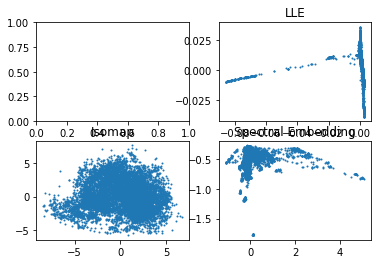

In [26]:
fig, axes = plt.subplots(nrows=2, ncols=2)
# axes[0, 0].scatter(embed_ltsa[:, 0], embed_ltsa[:, 1], s=1, c=color)
# axes[0, 0].set_title('LTSA')
axes[0, 1].scatter(embed_lle[:, 0], embed_lle[:, 1], s=1)
axes[0, 1].set_title('LLE')
axes[1, 0].scatter(embed_isomap[:, 0], embed_isomap[:, 1], s=1)
axes[1, 0].set_title('Isomap')
axes[1, 1].scatter(embed_spectral[:, 0], embed_spectral[:, 1], s=1)
axes[1, 1].set_title('Spectral Embedding')
plt.show()

Metrics

In [27]:
geom.laplacian_method = 'geometric'
geom.laplacian_kwds = {'scaling_epps':radius} # scaling ensures convergence to Laplace-Beltrami operator
laplacian_matrix = geom.compute_laplacian_matrix()


In [31]:
rmetric_spectral = RiemannMetric(embed_spectral, geom.laplacian_matrix)
H_spectral = rmetric_spectral.get_dual_rmetric()

# rmetric_ltsa = RiemannMetric(embed_ltsa, geom.laplacian_matrix)
# H_ltsa = rmetric_ltsa.get_dual_rmetric()

rmetric_lle = RiemannMetric(embed_lle, geom.laplacian_matrix)
H_lle = rmetric_lle.get_dual_rmetric()

rmetric_isomap = RiemannMetric(embed_isomap, geom.laplacian_matrix)
H_isomap = rmetric_isomap.get_dual_rmetric()


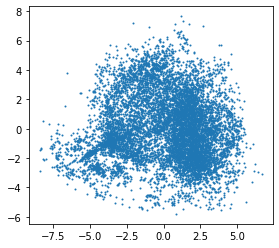

In [34]:
from megaman.utils.covar_plotter import plot_cov_ellipse

n_plot = 50
rng = np.random.RandomState(8675309)
sample_points = rng.choice(X.shape[0], n_plot, replace = False)

f, ax = plt.subplots()
ax.scatter(embed_isomap[:, 0], embed_isomap[:, 1], s = 1)
ax.set_aspect('equal') # if an ellipse is a circle no distortion occured.
for i in range(n_plot):
    ii = sample_points[i]
    cov = H_isomap[ii, :, :]
    plot_cov_ellipse(cov*0.05, embed_isomap[ii, :] ,ax=ax, edgecolor='none', alpha = 0.5)
plt.show()


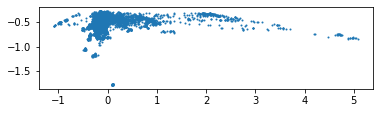

In [35]:
f, ax = plt.subplots()
ax.scatter(embed_spectral[:, 0], embed_spectral[:, 1], s = 1)
ax.set_aspect('equal') # if an ellipse is a circle no distortion occured.
for i in range(n_plot):
    ii = sample_points[i]
    cov = H_spectral[ii,:,:]
    plot_cov_ellipse(cov*0.01, embed_spectral[ii,:] ,ax=ax, edgecolor='none', alpha = 0.5)
plt.show()
